# Importing packages

In [10]:
import numpy as np
import seaborn as sns  # This package is only needed for pairplot
import matplotlib.pyplot as plt
import pyomo.environ as pyo
from pyomo.contrib.parmest import parmest
from pyomo.contrib.parmest.experiment import Experiment
from pyomo.contrib.doe import DesignOfExperiments
import pandas as pd
from itertools import product
import idaes

## Data

In [11]:
dat = [
    [76, 47], 
    [97, 107], 
    [123, 139], 
    [159, 152], 
    [191, 201], 
    [207, 200]]
dat_2 = np.array(dat).T
print(dat_2)

cov = np.cov(dat_2, rowvar=False)
var = np.diag(cov)
std = [np.sqrt(var[i]) for i in range(len(cov))]
print(std)

[[ 76  97 123 159 191 207]
 [ 47 107 139 152 201 200]]
[np.float64(20.506096654409877), np.float64(7.0710678118654755), np.float64(11.313708498984761), np.float64(4.949747468305833), np.float64(7.0710678118654755), np.float64(4.949747468305833)]


In [12]:
"""
This data and the equation (``Constraint``) in pyomo_model is from "Nonlinear Regression Analysis
and Its Applications - 1988 - Bates" p.33 Example

The equation: 
    reaction_velocity = theta[1] * substrate_concentration / (theta[2] + substrate_concentration)
    f(x, theta) = theta[1] * x / (theta[2] + x)
    
    -> theta[1] and theta[2] are parameters. we want to regress their values
    -> substrate concentration is the decison variable
    -> reaction_velocity is the response

"""
# substrate_concentration = np.array([0.02, 0.06, 0.11, 0.22, 0.56, 1.10])
substrate_concentration = [0.02, 0.06, 0.11, 0.22, 0.56, 1.10]

treated_velocity = [
    [76, 47], 
    [97, 107], 
    [123, 139], 
    [159, 152], 
    [191, 201], 
    [207, 200]]
untreated_velocity = np.array([
    [67, 51], 
    [84, 86], 
    [98, 115], 
    [131, 124], 
    [144, 158], 
    [160, np.nan]]
                             )

# calculate the average velocity. we are taking the average horizontally / along the rows. axis =1
treated_avg_velocity = np.nanmean(treated_velocity, axis = 1)  
treated_measurement_error = np.std(treated_velocity)
untreated_avg_velocity = np.nanmean(untreated_velocity, axis = 1)

data_f = {
    "substrate_concentration": substrate_concentration,
    "treated_avg_velocity": treated_avg_velocity,
    "untreated_avg_velocity": untreated_avg_velocity
       }

# Organizing the data in a list consisting of ``one key : one value dict``s
data_treated = [
    {"substrate_concentration" : float(sub_conc), "avg_velocity": float(treated_vel)} 
    for sub_conc, treated_vel in zip(data_f["substrate_concentration"], data_f["treated_avg_velocity"])
]

data_untreated = [
    {"substrate_concentration" : float(sub_conc), "avg_velocity": float(untreated_vel)} 
    for sub_conc, untreated_vel in zip(data_f["substrate_concentration"], data_f["untreated_avg_velocity"])
]


# **PARMEST & DOE**

### Creating an experiment class for both DOE and ParmEst

In [13]:
class ReactionVelocity(Experiment):

    # Defining the constructor
    def __init__(self, data):
        """
        Arguments:
            data -> data from our experiment
        """
        self.conc = data["substrate_concentration"]
        self.vel = data["avg_velocity"]
        self.model = None
        # initial guess of theta[1] & theta[2]
        self.theta_initial = {1: 100, 2: 0.05}

    # Creating the get_labeled_model which is a must for ``DOE`` and ``ParmEst``
    def get_labeled_model(self):
        if self.model is None:
            self.create_model()
            self.label_model()
            self.finalize_model()
        return self.model

    # Create the model. In create model we only set variables, parameters and equations 
    def create_model(self):
        m = self.model = pyo.ConcreteModel()

        # theta_1
        m.theta_1 = pyo.Var(domain = pyo.NonNegativeReals, initialize = self.theta_initial[1])
        m.theta_2 = pyo.Var(domain = pyo.NonNegativeReals, initialize = self.theta_initial[2])

        # substrate concentration (x) as a param, since the data is given          
        m.x = pyo.Var(domain = pyo.NonNegativeReals, initialize = self.conc)
        m.reaction_velocity = pyo.Var(domain = pyo.NonNegativeReals)

        # reaction_velocity = f(substrate_concentration, theta), is obtained from this equation.
        # So we will set it as an ``Expression``
        # m.reaction_velocity = pyo.Expression(expr = m.theta[1] * m.x / (m.theta[2] + m.x))        
        @m.Constraint()  # since the ``Constraint`` is not a set of anything, so there is no argument
        def vel_con(m):
            return m.reaction_velocity == m.theta_1 * m.x / (m.theta_2 + m.x)

        # m.con = pyo.Constraint(rule = vel_con)  

        # ======================================
        # Objective function
        """
        When I used the built in ``"SSE"``in parmest ``Estimator``, my model could not find LR ratio.
        That's why I created the ``Total_Cost_Obj`` to minimize the SSE. You can ignore this and use default "SSE". 
        Both ``FirstStageCost`` and ``SecondStageCost`` are required for the ``Objective``, otherwise it will show ``AttributeError``
        """
        
        # Stage-specific cost computation
        m.FirstStageCost = pyo.Expression(initialize = 0)
        m.SecondStageCost = pyo.Expression(expr = (self.vel - m.reaction_velocity) ** 2)

        m.Total_Cost_Obj = pyo.Objective(expr = (m.FirstStageCost + m.SecondStageCost), sense = pyo.minimize)
        # ======================================

            
        # m.pprint()
        
        return m

    
    def finalize_model(self):
        m=self.model

        # fixing the parameters
        m.theta_1.fix(self.theta_initial[1]) 
        m.theta_2.fix(self.theta_initial[2]) 

        # Add lower and upper bound to substrate concentration (control variable)
        m.x.setlb(0)
        m.x.setub(2)

        # fixing the substrate concentration (control variable)
        m.x.fix(self.conc)

        return m

    
    def label_model(self):
        """
        The model is updated with outputs, and unknown parameters. This makes the model labeled with full experiment.
        In `ParmEst` output (given data) is the most important. For `DOE` input is most important.
        """
        m = self.model

        # experiment outputs
        m.experiment_outputs = pyo.Suffix(direction = pyo.Suffix.LOCAL)  
        # m.experiment_outputs[m.reaction_velocity] = self.vel  # we can use either of these syntaxes(this one and the one below)
        m.experiment_outputs.update([(m.reaction_velocity, self.vel)])
        # If we only use ``DOE``, we could use ``m.experiment_ouputs.update([(m.x, None)])``.
        # Output is not important for ``DOE``

        # Experiment inputs
        m.experiment_inputs = pyo.Suffix(direction = pyo.Suffix.LOCAL)    
        # m.experiment_inputs[m.x] = self.conc
        m.experiment_inputs.update([(m.x, self.conc)])
        # If we only use ``DOE``, we could use ``m.experiment_inputs.update([(m.x, None)])``

        # Unknown parameters
        m.unknown_parameters = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        m.unknown_parameters.update((p, pyo.value(p)) for p in [m.theta_1, m.theta_2])
        # m.unknown_parameters[m.theta_1]= self.theta_initial[1]
        # m.unknown_parameters[m.theta_2]= self.theta_initial[2]

        m.measurement_error = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        # m.measurement_error[m.reaction_velocity] = 0.03
        m.measurement_error.update([(m.reaction_velocity, 0.03**2)])  # variance of the measurement error
        # m.measurement_error.update([(m.reaction_velocity, 0.03**2)])  # for ``DOE`` we need to square the std. 
        # b/c in doe, the measurement error is passed as variance, not std

        return m

## Parmest Example

### Treated velocity

In [15]:
exp_list = []  
conc = substrate_concentration
vel = treated_avg_velocity
n_exp = len(data_treated)

# exp_list to separate each experiment
for i in range(n_exp):
    exp_list.append(ReactionVelocity(data_treated[i]))

# Creating an Estimator object
pest = parmest.Estimator(exp_list, tee = False)  

# obj, theta = pest.theta_est()
obj, theta, cov = pest.theta_est(calc_cov=True, cov_n=n_exp)

# ``parmest`` can mess up the order of the theta estimates and also the covariance. 
# So we need to fix the order so that we can manipulate it properly.
t_order = ["theta_1", "theta_2"]
theta_perm = theta.loc[t_order]  # ``theta`` in the order we want
cov_perm = cov.loc[t_order, t_order]  # ``covariance`` matrix in the order we want

print("\n\ntheta values:")
print(theta_perm)

print("\nSSE value: ", obj)

print("\nCovariance matrix:")
print(cov_perm)



theta values:
theta_1    212.683743
theta_2      0.064121
dtype: float64

SSE value:  41.495734536613284

Covariance matrix:
           theta_1   theta_2
theta_1  47.672886  0.041806
theta_2   0.041806  0.000065


### Untreated velocity

In [6]:
exp_list = []  
n_exp = len(data_untreated)

# exp_list to separate each experiment
for i in range(n_exp):
    exp_list.append(ReactionVelocity(data_untreated[i]))

# Creating an Estimator object
pest = parmest.Estimator(exp_list, tee = False)  

# obj, theta = pest.theta_est()
obj_u, theta_u, cov_u = pest.theta_est(calc_cov=True, cov_n=n_exp)

# ``parmest`` can mess up the order of the theta estimates and also the covariance. 
# So we need to fix the order so that we can manipulate it properly.
t_order = ["theta_1", "theta_2"]
theta_ordered_u = theta_u.loc[t_order]  # ``theta`` in the order we want
cov_ordered_u = cov_u.loc[t_order, t_order]  # ``covariance`` matrix in the order we want

print("\n\ntheta values:")
print(theta_ordered_u)

print("\nSSE value: ", obj_u)

print("\nCovariance matrix:")
print(cov_ordered_u)



theta values:
theta_1    162.214170
theta_2      0.049467
dtype: float64

SSE value:  41.08777008727723

Covariance matrix:
           theta_1   theta_2
theta_1  39.567323  0.036410
theta_2   0.036410  0.000064


### Likelyhood ratio 

In [7]:
""" # remove the comment if you want to run
# creating theta values where we want to find the LR
theta_1 = np.linspace(150, 250, 10)
theta_2 = np.linspace(0.03, 0.07, 10)

# creating a DF using these theta values
theta_vals = pd.DataFrame(
    list(product(theta_1, theta_2)), columns=["theta_1", "theta_2"]  
    # Names of the theta values as we defined in ``create_model``. our theta was basically a ``dict``
)

# Objective values for each theta value. Pre-requiste method for ``likelihood_ratio_test``
obj_at_theta = pest.objective_at_theta(theta_vals)

# Likelihood Ratio Test : to identify theta values within a confidence region using the distribution
LR = pest.likelihood_ratio_test(obj_at_theta, obj, [0.8, 0.85, 0.9, 0.95])
# the ``obj` here is from ``obj, theta, cov = pest.theta_est(calc_cov=True, cov_n=n_data)``.
# The [0.8, 0.85, 0.9, 0.95] list is  alpha values (Confidence Level) for `chi2`` test
"""

' # remove the comment if you want to run\n# creating theta values where we want to find the LR\ntheta_1 = np.linspace(150, 250, 10)\ntheta_2 = np.linspace(0.03, 0.07, 10)\n\n# creating a DF using these theta values\ntheta_vals = pd.DataFrame(\n    list(product(theta_1, theta_2)), columns=["theta_1", "theta_2"]  \n    # Names of the theta values as we defined in ``create_model``. our theta was basically a ``dict``\n)\n\n# Objective values for each theta value. Pre-requiste method for ``likelihood_ratio_test``\nobj_at_theta = pest.objective_at_theta(theta_vals)\n\n# Likelihood Ratio Test : to identify theta values within a confidence region using the distribution\nLR = pest.likelihood_ratio_test(obj_at_theta, obj, [0.8, 0.85, 0.9, 0.95])\n# the ``obj` here is from ``obj, theta, cov = pest.theta_est(calc_cov=True, cov_n=n_data)``.\n# The [0.8, 0.85, 0.9, 0.95] list is  alpha values (Confidence Level) for `chi2`` test\n'

### Pairwise_plot (theta values - confidence level)

In [9]:
# Create plot pairwise relationship for theta values, and optionally alpha-level confidence intervals and objective value contours
# `theta` here is from ``obj, theta, cov = pest.theta_est(calc_cov=True, cov_n=n_data)``.
parmest.graphics.pairwise_plot(LR, theta, 0.95, title= "Likelihood Ratio results within 95% confidence region")

# the blue dots (``thetas``), represent the values at which the ``LR`` is true with the mentioned confidence level


' # remove this comment to run\n# Create plot pairwise relationship for theta values, and optionally alpha-level confidence intervals and objective value contours\n# `theta` here is from ``obj, theta, cov = pest.theta_est(calc_cov=True, cov_n=n_data)``.\nparmest.graphics.pairwise_plot(LR, theta, 0.95, title= "Likelihood Ratio results within 95% confidence region")\n\n# the blue dots (``thetas``), represent the values at which the ``LR`` is true with the mentioned confidence level\n'

### bootstrap

In [10]:
pest = parmest.Estimator(exp_list)
bootstrap_theta = pest.theta_est_bootstrap(50, seed=4581)

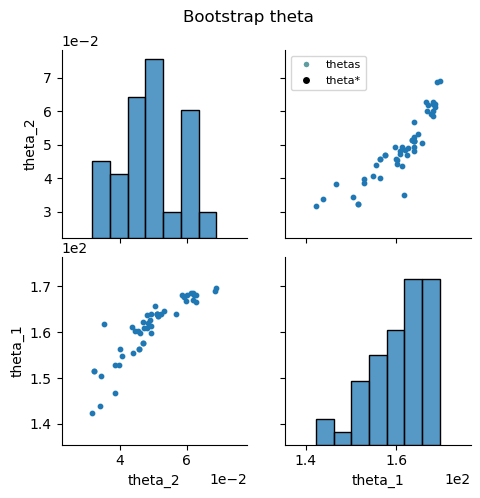

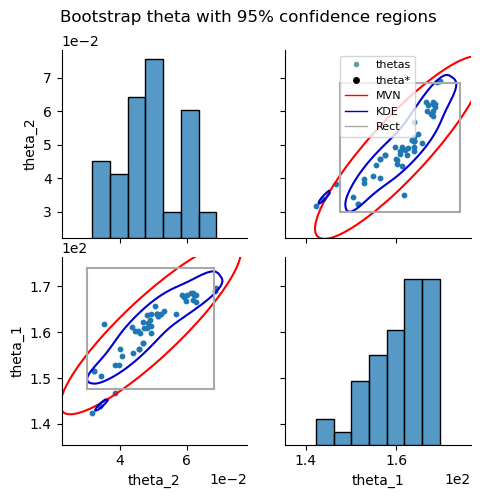

In [11]:
parmest.graphics.pairwise_plot(bootstrap_theta, theta, title='Bootstrap theta')
parmest.graphics.pairwise_plot(
    bootstrap_theta,
    theta,
    0.95,
    ['MVN', 'KDE', 'Rect'],
    title='Bootstrap theta with 95% confidence regions',
)

## DOE Example

In [55]:
def run_reactor_doe():
    FIM = []
    for i in range(n_exp):
        # Create a ReactorVelocity object for each experiment
        experiment = ReactionVelocity(data_treated[i])

        scale_nominal_param_value = False
        doe_obj = DesignOfExperiments(
            experiment,
            scale_nominal_param_value=scale_nominal_param_value,
            tee=False
        )        
        # I haven't defined the other parameters, because the defaults values are used in the doe example.
        
        FIM.append(doe_obj.compute_FIM())
    return FIM
    
FIM = run_reactor_doe()
FIM_total = sum(FIM[i] for i in range(len(FIM)))
cov_doe = np.linalg.inv(FIM_total)
print("\nCov of theExperiment using ``DOE``\n", cov_doe)


Cov of theExperiment using ``DOE``
 [[6.23566209e-04 9.96715573e-07]
 [9.96715573e-07 2.84958412e-09]]


# **Plotting**

### Plot with regression values

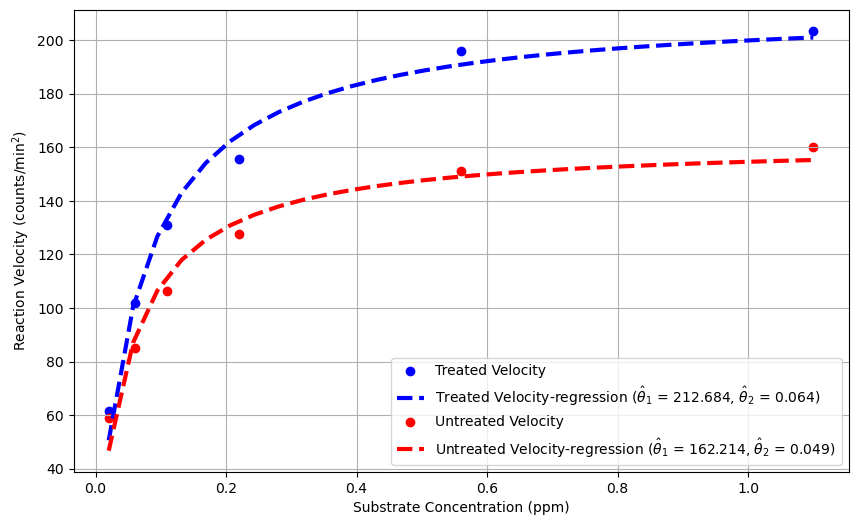

In [13]:
vel = lambda sub_conc, theta: theta.loc["theta_1"] * sub_conc / ( theta.loc["theta_2"] + sub_conc)

sub_c = np.linspace(data_f["substrate_concentration"][0], data_f["substrate_concentration"][-1], 30)

plt.figure(figsize=(10, 6))
# treated data
plt.scatter(substrate_concentration, treated_avg_velocity, color = "blue", label = 'Treated Velocity')
plt.plot(sub_c, vel(sub_c, theta), lw =3, ls ="--", color = "blue", 
         label=(rf'Treated Velocity-regression ($\hat\theta_1$ ={theta.loc["theta_1"] : 0.3f}, $\hat\theta_2$ ={theta.loc["theta_2"]: 0.3f})'))

# untreated data
plt.scatter(substrate_concentration, untreated_avg_velocity, color = "red", label = 'Untreated Velocity')
plt.plot(sub_c, vel(sub_c, theta_u), lw =3, ls ="--", color = "red", 
         label=(rf'Untreated Velocity-regression ($\hat\theta_1$ ={theta_u.loc["theta_1"] : 0.3f}, $\hat\theta_2$ ={theta_u.loc["theta_2"]: 0.3f})'))
plt.xlabel("Substrate Concentration (ppm)")
plt.ylabel("Reaction Velocity (counts/min$^2$)")
plt.grid()
plt.legend()

### Confidence Region
The following sections used only treated velocity. Untreated velocity was not used. Since we can do that simpy by changing the data. The process stays the same.

Text(0.5, 1.0, 'Treated Fit with Confidence Region')

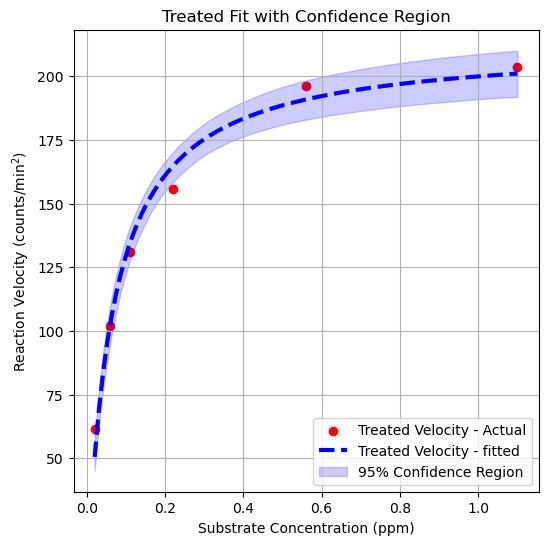

In [15]:
CI = 95  # The confidence interval 

# Calculate the standard errors (square root of diagonal elements of covariance matrix)
# Converting pd DF to numpy nd array
cov_n = cov_perm.to_numpy()
theta_n = theta_perm.to_numpy()
perr = np.sqrt(np.diag(cov_n))  

# Our model equation
rxn_vel = lambda sub_conc, theta_p: theta_p[0] * sub_conc / ( theta_p[1] + sub_conc)

# Generate confidence bounds using Monte Carlo sampling
n_samples = 1000  # number of parameter samples
theta_samples = np.random.multivariate_normal(theta_n, cov_n, size = n_samples)

# Generate fitted curves for each sampled parameter set
S_range = np.linspace(min(data_f["substrate_concentration"]), max(data_f["substrate_concentration"]), 100)
predicted_curves = np.array([rxn_vel(S_range, theta_val) for theta_val in theta_samples])

# Compute the confidence band
lower_bound = np.percentile(predicted_curves, 100 - CI, axis=0)
upper_bound = np.percentile(predicted_curves, CI, axis=0)

# Plot the 95% inference band
plt.figure(figsize=(6,6))
#sub_c = np.linspace(data_f["substrate_concentration"][0], data_f["substrate_concentration"][-1], 30)

plt.scatter(data_f["substrate_concentration"], data_f["treated_avg_velocity"], color = "red", label = "Treated Velocity - Actual")
plt.plot(S_range, rxn_vel(S_range, theta_n), lw =3, ls ="--", color = "blue", label="Treated Velocity - fitted")
plt.fill_between(S_range, lower_bound, upper_bound, color = "blue", alpha=0.2, label=f"{CI}% Confidence Region")
plt.xlabel("Substrate Concentration (ppm)")
plt.ylabel("Reaction Velocity (counts/min$^2$)")
plt.grid()
plt.legend()
plt.title("Treated Fit with Confidence Region")

In [ ]:
cov

### Joint parameter confidence region (Confidence Ellipsoid)

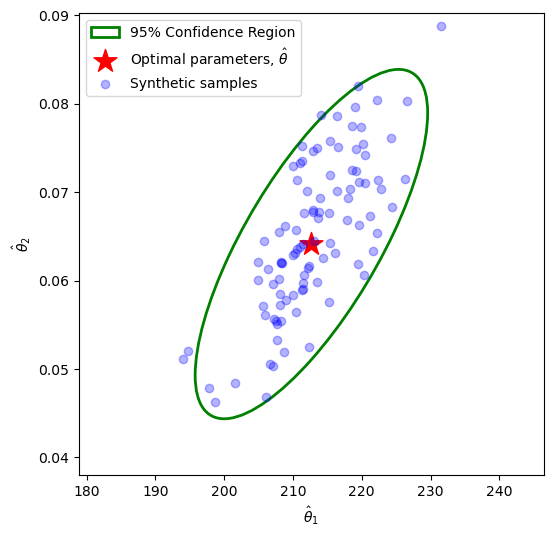

In [16]:
import scipy.stats as stat
from matplotlib.patches import Ellipse

CI = 95  # The confidence interval 

# Create the Ellipse object to represent the confidence region
eigvals, eigvecs = np.linalg.eigh(cov_n)
order = eigvals.argsort()[::-1]  # returns the descending order index of the eigen values.
eigvals, eigvecs = eigvals[order], eigvecs[:, order]  # reorder

# Define angle and width/height of the ellipse
chi2_val = stat.chi2.ppf(CI/100, df=2)  # Chi-square value for %CI, df -> 2 degrees of freedom (two parameters)
scale_factor = np.sqrt(chi2_val)
width, height = 2 * scale_factor * np.sqrt(eigvals)  # scaling for 95% Cofidence
angle = np.arctan2(eigvecs[1, 0], eigvecs[0, 0]) * 180 / np.pi

#angle = np.arctan2(*eigvecs[:,0][::-1]) * 180 / np.pi

# Plot the confidence ellipse
fig, ax = plt.subplots(figsize=(6, 6))

# Create the ellipse object
ellipse = Ellipse(xy=theta_n, width=width, height=height, angle=angle, facecolor='none', edgecolor="green", lw=2, label=f"{CI}% Confidence Region")
ax.add_patch(ellipse)

# add labels and formatting
ax.set_xlabel(r"$\hat\theta_1$")
ax.set_ylabel(r"$\hat\theta_2$")
ax.scatter(theta_n[0], theta_n[1], color="red", marker="*", s=300, label = r"Optimal parameters, $\hat\theta$")
# Set proper limits based on ellipse size
ax.set_xlim(theta_n[0] - width, theta_n[0] +  width)
ax.set_ylim(theta_n[1] - height, theta_n[1] + height)

# To plot some random synthetic data points for our optimum theta.
# In reality our theta value could be any of these random points.
n_samples = 100  # number of scatter points we want to plot
np.random.seed(101)
theta_samples = np.random.multivariate_normal(theta_n, cov_n, size = n_samples)
ax.scatter(theta_samples[:, 0], theta_samples[:, 1], color='blue', alpha=0.3, label="Synthetic samples")
ax.legend()

# **Scipy**

In [17]:
# Data
substrate_concentration = np.array([0.02, 0.06, 0.11, 0.22, 0.56, 1.10])
treated_velocity = np.array([
    [76, 47], 
    [97, 107], 
    [123, 139], 
    [159, 152], 
    [191, 201], 
    [207, 200]])

treated_avg_velocity = np.nanmean(treated_velocity, axis = 1)

In [18]:
from scipy.optimize import minimize, curve_fit

In [19]:
def rxn_vel(x, theta_1, theta_2):  # ``curve_fit`` expects the parameters to be separate arguments. And independet variable should be the first argument
    return theta_1 * x / (theta_2 + x)
    
def SSE(theta, x, y):  # the minimizer variable should be passed in as the first argument and as a vector.
    y_pred = theta[0] * x / (theta[1] + x)
    return np.sum((y - y_pred)**2)

## Minimize

In [34]:
theta_initial = [200, 0.05]
result = minimize(SSE, theta_initial, args=(substrate_concentration, treated_avg_velocity), method="Nelder-Mead")
# ``args `` -> the extra parameters that should be passed in the objective function. 
# In this case, x -> substrate_concentration and y -> treated_avg_velocity
result.x

array([2.12683777e+02, 6.41213441e-02])

## Curve fit

In [42]:
sig_cf = 0.03  # measurement error
popt, pcov = curve_fit(rxn_vel, substrate_concentration, treated_avg_velocity, absolute_sigma=True, sigma=sig_cf, p0=result.x)
print("theta[1] = ", popt[0])
print("theta[2] = ", popt[1])
theta_names = ['theta[1]', 'theta[2]']
pcov = pd.DataFrame(pcov, index=theta_names, columns=theta_names)


theta[1] =  212.68374709751455
theta[2] =  0.06412128784705177


## Least squares

In [22]:
from scipy import stats, optimize
import math

In [23]:
# Define the regression model
def reg_fit(theta, x):  
    yhat = theta[0] * x / (theta[1] + x)
    return yhat

# define the residuals
def residuals(theta, x, y): # the parameters must be vector for scipy least squares and passed as the first argument
    e = y - reg_fit(theta, x)
    return e

In [24]:
# actual data
n_exp = len(treated_avg_velocity)
x = np.array(substrate_concentration)
y_ac = np.nanmean(treated_velocity, axis = 1)  
y_ac += np.random.normal(scale=0.03, size=n_exp)  # add a random noise to the measurement data

# initial guess of the parameters
theta0 = np.array([200, 0.05])

# bounds
bnds = ([0, 0], [np.inf, np.inf])

# least squares regression
sc_results = optimize.least_squares(residuals, theta0, bounds=bnds, args=(x, y_ac))

theta = sc_results.x
theta

array([2.12683044e+02, 6.40828158e-02])

### Uncertainty analysis (Covariance matrix)

In [38]:
jaco = sc_results.jac  # jacobian of the cost function 
er = sc_results.fun  # sc_results.fun is actually the residual at our optimized theta values

# Calculate the variance of measurement error (noise)
sig2re = 0.03**2 # (er.T @ er) / (len(er) - 2)  # 2 is the number of parameters
# If we don't know the value of sigma^2 for measurement error, we use this formula, otherwise we use the measurent error as sig2re

# Calculate the covariance matrix of the parameters
cov_ls = sig2re * np.linalg.inv(jaco.T @ jaco)
print("\nCov of theExperiment using ``Least Squares``\n", cov_ls)


Cov of theExperiment using ``Least Squares``
 [[7.26418123e-04 6.62162305e-07]
 [6.62162305e-07 1.03127029e-09]]


In [35]:
sig2re

np.float64(62.019299585423525)

In [26]:
sc_results

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 1.090e+01 -8.106e-01 -3.338e+00 -9.186e+00  5.161e+00
                2.530e+00]
           x: [ 2.127e+02  6.408e-02]
        cost: 124.03859917084705
         jac: [[-2.379e-01  6.017e+02]
               [-4.835e-01  8.288e+02]
               [-6.319e-01  7.720e+02]
               [-7.744e-01  5.798e+02]
               [-8.973e-01  3.058e+02]
               [-9.449e-01  1.726e+02]]
        grad: [ 4.274e-08 -1.914e-02]
  optimality: 0.01914216134126253
 active_mask: [0 0]
        nfev: 7
        njev: 7

In [27]:
sig2re

np.float64(62.019299585423525)

#  Monte Carlo Uncertainty analysis

In [59]:
n_mc = 1000  # number of monte carlo sample points
np.random.seed(101)
substrate_concentration = np.array([0.02, 0.06, 0.11, 0.22, 0.56, 1.10])
theta_p = theta_perm.to_numpy()  # use the fitted parameter values
rxn_vel_mc = lambda sub_conc: theta_p[0] * sub_conc / ( theta_p[1] + sub_conc)
model_pred = rxn_vel_mc(substrate_concentration)  # model predictions for the ``substrate_concentration``
measurement_err = 0.03  # measurement error
n_exp = len(model_pred)

# for loop for mc sampling
mc_s = []  # empty list for our ``response`` with ``measurement error``
for i in range(n_mc):
    random_err = stats.norm.rvs(scale=measurement_err, size=n_exp)
    pred_w_err = model_pred + random_err  # adding random error to our model predictions
    mc_s.append(pred_w_err)    

### Parameter Estimation

In [62]:
# exp_list to separate each experiment
t_order = ["theta_1", "theta_2"]  # the order of ``theta`` we want
col_names = ["substrate_concentration", "avg_velocity"]
theta_values = np.zeros((n_mc, 2))

import time
start_time = time.time()  # Start timer

for i in range(n_mc):  # this for loop can be merged with the for loop in  the cell above
    vel_mc = mc_s[i]
    # veritcally stacking the ``substrate_concentration`` and our predicted velocity w/ measurement error
    data_con = np.vstack((substrate_concentration, mc_s[i])).T   
    df = pd.DataFrame(data_con, columns=col_names)

    exp_list = []
    for j in range(n_exp):
        exp_list.append(ReactionVelocity(df.iloc[j]))

    # Creating an Estimator object
    pest = parmest.Estimator(exp_list, tee = False)  
    
    # obj, theta = pest.theta_est()
    obj, theta = pest.theta_est()
    theta_ordered = theta.loc[t_order].to_numpy()
    theta_values[i, :] = theta_ordered


end_time = time.time()   
print(f"Execution time: {end_time - start_time: 0.6f} seconds")  

Execution time:  26.081079 seconds


In [33]:
# Calculating Covariance matrix using MC
cov_mc = np.cov(theta_values, rowvar=False)
cov_mc

array([[7.91094359e-04, 7.14627770e-07],
       [7.14627770e-07, 1.05901655e-09]])

# Covariance matrix using different packages

In [56]:
print("Cov of the using SciPy ``Curve Fit``:\n", pcov)
print("\nCov of the Experiment using ``Least Squares``\n", cov_ls)
print("\nCov of the Experiment using ``ParmEst``\n", cov_perm)
print("\nCov of the Experiment using ``DOE``\n", cov_doe)
print("\nCov of the Experiment using ``Monte Carlo``\n", cov_mc)

Cov of the using SciPy ``Curve Fit``:
               theta[1]      theta[2]
theta[1]  7.267010e-04  6.627323e-07
theta[2]  6.627323e-07  1.032530e-09

Cov of the Experiment using ``Least Squares``
 [[7.26418123e-04 6.62162305e-07]
 [6.62162305e-07 1.03127029e-09]]

Cov of the Experiment using ``ParmEst``
            theta_1   theta_2
theta_1  47.672886  0.041806
theta_2   0.041806  0.000065

Cov of the Experiment using ``DOE``
 [[6.23566209e-04 9.96715573e-07]
 [9.96715573e-07 2.84958412e-09]]

Cov of the Experiment using ``Monte Carlo``
 [[7.91094359e-04 7.14627770e-07]
 [7.14627770e-07 1.05901655e-09]]
